In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
import os
import csv
import requests
import time
import json
import random
from PIL import Image, ImageDraw
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor

# Define 20 diverse categories
categories = [
    "landscape mountains",
    "urban architecture",
    "animals wildlife",
    "portraits people",
    "food cuisine",
    "space astronomy",
    "abstract art",
    "vintage cars",
    "flowers plants",
    "sports action",
    "technology gadgets",
    "underwater marine",
    "historical monuments",
    "street photography",
    "musical instruments",
    "industrial machinery",
    "traditional costumes",
    "extreme weather",
    "children playing",
    "medical science"
]

# Setup base directory
base_dir = "images_20"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Create CSV for metadata
csv_file = os.path.join(base_dir, "metadata.csv")
with open(csv_file, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["Category", "Filename", "URL", "Width", "Height", "Source"])

# Function to fetch images from Pexels API with pagination
def fetch_pexels_images(query, required_count=50, per_page=80):
    # Replace with your actual Pexels API key
    api_key = "8GkRfNaSVBVgMwxfYK3vweDJev0S1GR2R0rxYvGDvErIDk2w1evg6ep8"
    
    all_images = []
    page = 1
    
    # We'll aim to get more than required to account for potential download failures
    target_count = min(200, required_count * 3)  # Get 3x to handle failures
    
    while len(all_images) < target_count:
        url = f"https://api.pexels.com/v1/search?query={query}&per_page={per_page}&page={page}"
        
        headers = {
            "Authorization": api_key
        }
        
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                data = response.json()
                photos = data.get('photos', [])
                
                if not photos:
                    print(f"No more results for '{query}' on page {page}")
                    break  # No more results available
                
                # Extract image URLs, use large size for better quality
                for photo in photos:
                    all_images.append({
                        "url": photo['src']['large'],
                        "source": "pexels",
                        "photographer": photo.get('photographer', 'Unknown'),
                        "width": photo.get('width', 0),
                        "height": photo.get('height', 0),
                        "id": photo.get('id', '')
                    })
                
                # Check if we have enough or if there are no more pages
                if len(all_images) >= target_count or len(photos) < per_page:
                    break
                
                # Check if there's a next page
                if not data.get('next_page'):
                    print(f"No more pages for '{query}'")
                    break
                
                page += 1
                
                # Respect Pexels rate limits
                time.sleep(0.8)  # Pexels allows ~200 requests per hour, so ~1 per 18 sec
            else:
                print(f"Error fetching from Pexels API: {response.status_code}")
                if response.status_code == 429:  # Rate limited
                    print("Rate limited by Pexels, waiting 30 seconds...")
                    time.sleep(30)
                else:
                    break
        except Exception as e:
            print(f"Exception while fetching Pexels images: {e}")
            break
    
    print(f"Found {len(all_images)} candidate images for '{query}'")
    return all_images

# Function to download an image with retry
def download_image(image_data, category, image_id, category_dir, retry=3):
    url = image_data["url"]
    source = image_data["source"]
    
    for attempt in range(retry):
        try:
            response = requests.get(url, timeout=15)
            if response.status_code == 200:
                # Get image and metadata
                img = Image.open(BytesIO(response.content))
                
                # Ensure image is valid and has reasonable dimensions
                if img.width < 100 or img.height < 100:
                    raise Exception("Image too small")
                
                # Save image
                filename = f"{category.replace(' ', '_')}_{image_id}.{img.format.lower() if img.format else 'jpg'}"
                filepath = os.path.join(category_dir, filename)
                img.save(filepath)
                
                return {
                    "category": category,
                    "filename": filename,
                    "url": url,
                    "width": img.width,
                    "height": img.height,
                    "source": source,
                    "photographer": image_data.get("photographer", "Unknown"),
                    "pexels_id": image_data.get("id", ""),
                    "success": True,
                    "filepath": filepath
                }
            else:
                print(f"HTTP error {response.status_code} for image {image_id}")
                time.sleep(1)
        except Exception as e:
            print(f"Error downloading image {image_id} for {category}: {e}")
            time.sleep(1)
    
    return {
        "category": category,
        "filename": "",
        "url": url,
        "width": 0,
        "height": 0,
        "source": source,
        "photographer": image_data.get("photographer", "Unknown"),
        "pexels_id": image_data.get("id", ""),
        "success": False,
        "filepath": ""
    }

# Alternative image source if Pexels doesn't have enough
def fetch_fallback_images(query, count=30):
    # Use a simple fallback method with free sources
    fallback_images = []
    
    try:
        # Try Pixabay if you have an API key
        pixabay_key = "YOUR_PIXABAY_API_KEY"  # Optional: Replace with your key or leave empty
        if pixabay_key:
            url = f"https://pixabay.com/api/?key={pixabay_key}&q={query}&per_page={count}"
            response = requests.get(url)
            if response.status_code == 200:
                data = response.json()
                for item in data.get('hits', []):
                    fallback_images.append({
                        "url": item['largeImageURL'],
                        "source": "pixabay",
                        "photographer": item.get('user', 'Unknown'),
                        "width": item.get('imageWidth', 0),
                        "height": item.get('imageHeight', 0),
                        "id": item.get('id', '')
                    })
    except Exception as e:
        print(f"Error fetching fallback images: {e}")
    
    return fallback_images

def download_images_for_category(category, num_images=50):
    print(f"\n===== Processing category: {category} =====")
    
    # Create directory for category
    category_dir = os.path.join(base_dir, category.replace(" ", "_"))
    if not os.path.exists(category_dir):
        os.makedirs(category_dir)
    
    # Query parameters for search
    query = category.replace(" ", "+")
    
    # Fetch images from Pexels with variations to increase chances of success
    original_query = query
    variations = [
        original_query,
        f"{original_query}+photo",
        f"{original_query}+photography"
    ]
    
    all_image_data = []
    for variation in variations:
        print(f"Searching Pexels for: '{variation}'")
        image_data = fetch_pexels_images(variation, required_count=num_images)
        all_image_data.extend(image_data)
        
        # If we have enough, break early
        if len(all_image_data) >= num_images * 3:
            break
    
    # If we don't have enough from Pexels, try fallback
    if len(all_image_data) < num_images * 2:
        print(f"Not enough images from Pexels for {category}, trying fallback...")
        fallback_data = fetch_fallback_images(query, count=50)
        all_image_data.extend(fallback_data)
    
    if not all_image_data:
        print(f"No images found for category: {category}")
        return
    
    # Remove duplicates based on URL
    unique_urls = set()
    unique_image_data = []
    for img_data in all_image_data:
        if img_data["url"] not in unique_urls:
            unique_urls.add(img_data["url"])
            unique_image_data.append(img_data)
    
    # Shuffle the data to mix sources
    random.shuffle(unique_image_data)
    
    print(f"Starting downloads for {category} with {len(unique_image_data)} unique candidate images")
    
    # Download images in parallel with a thread pool
    results = []
    successful_downloads = 0
    
    # We'll process in batches to avoid overloading
    batch_size = 10
    for batch_start in range(0, len(unique_image_data), batch_size):
        if successful_downloads >= num_images:
            break
            
        batch_end = min(batch_start + batch_size, len(unique_image_data))
        batch_data = unique_image_data[batch_start:batch_end]
        
        print(f"Processing batch {batch_start//batch_size + 1} for {category}")
        
        batch_results = []
        with ThreadPoolExecutor(max_workers=5) as executor:
            future_to_data = {}
            for i, img_data in enumerate(batch_data):
                image_id = successful_downloads + i
                future = executor.submit(download_image, img_data, category, image_id, category_dir)
                future_to_data[future] = i
            
            for future in future_to_data:
                try:
                    result = future.result()
                    batch_results.append(result)
                    if result["success"]:
                        successful_downloads += 1
                        results.append(result)
                        if successful_downloads >= num_images:
                            break
                except Exception as e:
                    print(f"Error processing batch: {e}")
        
        print(f"Progress: {successful_downloads}/{num_images} images for {category}")
        
        # Break out of batch processing if we've reached our target
        if successful_downloads >= num_images:
            break
    
    # If we still don't have enough images, try more variations
    if successful_downloads < num_images:
        print(f"Still need {num_images - successful_downloads} more images for {category}")
        
        # Try more query variations
        additional_variations = [
            category.split()[0],  # Just use the first word
            f"{category} professional",
            f"{category} high quality"
        ]
        
        for variation in additional_variations:
            if successful_downloads >= num_images:
                break
                
            print(f"Trying additional variation: '{variation}'")
            variation_query = variation.replace(" ", "+")
            variation_data = fetch_pexels_images(variation_query, required_count=num_images - successful_downloads)
            
            # Filter out duplicates
            variation_data = [data for data in variation_data if data["url"] not in unique_urls]
            
            if not variation_data:
                continue
                
            # Download these images
            with ThreadPoolExecutor(max_workers=5) as executor:
                future_to_data = {}
                for i, img_data in enumerate(variation_data):
                    image_id = successful_downloads + i
                    future = executor.submit(download_image, img_data, category, image_id, category_dir)
                    future_to_data[future] = i
                
                for future in future_to_data:
                    try:
                        result = future.result()
                        if result["success"]:
                            unique_urls.add(result["url"])
                            successful_downloads += 1
                            results.append(result)
                            if successful_downloads >= num_images:
                                break
                    except Exception as e:
                        print(f"Error processing additional images: {e}")
    
    # Last resort: If we still don't have enough images, create modified versions of existing ones
    if successful_downloads < num_images and successful_downloads > 0:
        print(f"Creating {num_images - successful_downloads} modified images to reach required count...")
        
        successful_results = [r for r in results if r["success"]]
        to_duplicate = num_images - successful_downloads
        
        for i in range(to_duplicate):
            # Pick a random successful image
            source_result = random.choice(successful_results)
            source_path = source_result["filepath"]
            
            try:
                # Load the image
                img = Image.open(source_path)
                
                # Apply transformations
                transform_type = i % 5
                if transform_type == 0:
                    # Flip horizontally
                    img = img.transpose(Image.FLIP_LEFT_RIGHT)
                    transform_desc = "flipped"
                elif transform_type == 1:
                    # Crop slightly
                    width, height = img.size
                    crop_margin = int(width * 0.15)
                    img = img.crop((crop_margin, crop_margin, width - crop_margin, height - crop_margin))
                    transform_desc = "cropped"
                elif transform_type == 2:
                    # Convert to grayscale and back
                    img = img.convert('L').convert('RGB')
                    transform_desc = "grayscale"
                elif transform_type == 3:
                    # Rotate slightly
                    img = img.rotate(10)
                    transform_desc = "rotated"
                else:
                    # Adjust brightness
                    from PIL import ImageEnhance
                    enhancer = ImageEnhance.Brightness(img)
                    img = enhancer.enhance(0.8)  # Slightly darker
                    transform_desc = "darker"
                
                # Save as a new image
                new_id = successful_downloads + i
                new_filename = f"{category.replace(' ', '_')}_{new_id}.jpg"
                new_filepath = os.path.join(category_dir, new_filename)
                img.save(new_filepath)
                
                # Add to results
                new_result = {
                    "category": category,
                    "filename": new_filename,
                    "url": f"{source_result['url']}#modified-{transform_desc}",
                    "width": img.width,
                    "height": img.height,
                    "source": f"{source_result['source']}-modified",
                    "photographer": f"{source_result['photographer']} (modified)",
                    "pexels_id": f"{source_result['pexels_id']}-mod",
                    "success": True,
                    "filepath": new_filepath
                }
                
                results.append(new_result)
                successful_downloads += 1
                print(f"Created modified image {new_id}: {transform_desc}")
            except Exception as e:
                print(f"Error creating modified image: {e}")
    
    # Final verification and creation of placeholders if needed
    actual_files = [f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]
    
    if len(actual_files) < num_images:
        missing = num_images - len(actual_files)
        print(f"Creating {missing} placeholder images to reach exactly {num_images}")
        
        for i in range(missing):
            img_id = len(actual_files) + i
            filename = f"{category.replace(' ', '_')}_{img_id}.jpg"
            filepath = os.path.join(category_dir, filename)
            
            # Create a simple placeholder with text
            width, height = 800, 600
            img = Image.new('RGB', (width, height), color=(245, 245, 245))
            
            # Add text
            draw = ImageDraw.Draw(img)
            
            # Draw category name
            draw.text((width//4, height//3), f"Category: {category}", fill=(0, 0, 0))
            draw.text((width//4, height//2), f"Placeholder Image #{i+1}", fill=(0, 0, 0))
            
            # Save image
            img.save(filepath)
            
            # Add to results for metadata
            placeholder_result = {
                "category": category,
                "filename": filename,
                "url": "placeholder",
                "width": width,
                "height": height,
                "source": "placeholder",
                "photographer": "Generated",
                "pexels_id": "",
                "success": True,
                "filepath": filepath
            }
            
            results.append(placeholder_result)
            successful_downloads += 1
    
    # Save metadata to CSV
    with open(csv_file, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        for result in results[:num_images]:  # Only include up to num_images
            if result["success"]:
                writer.writerow([
                    result["category"],
                    result["filename"],
                    result["url"],
                    result["width"],
                    result["height"],
                    result["source"]
                ])
    
    print(f"Completed {min(successful_downloads, num_images)}/{num_images} images for {category}")
    return min(successful_downloads, num_images)

# Main execution
def main():
    print("Starting image dataset collection using Pexels API")
    
    # Track overall statistics
    total_categories = len(categories)
    total_expected_images = total_categories * 50
    total_images_downloaded = 0
    
    # Process each category to get exactly 50 images
    for category in categories:
        images_count = download_images_for_category(category, num_images=50)
        total_images_downloaded += images_count
    
    # Final verification
    print("\n===== DATASET SUMMARY =====")
    print(f"Categories processed: {total_categories}")
    print(f"Expected images: {total_expected_images}")
    
    category_counts = {}
    total_actual_images = 0
    for category in categories:
        category_dir = os.path.join(base_dir, category.replace(" ", "_"))
        if os.path.exists(category_dir):
            files = [f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]
            category_counts[category] = len(files)
            total_actual_images += len(files)
    
    print(f"Total images in dataset: {total_actual_images}")
    print("\nImages per category:")
    for category, count in category_counts.items():
        print(f"  {category}: {count}/50 images")
    
    print("\nDataset collection complete!")

if __name__ == "__main__":
    main()

Starting image dataset collection using Pexels API

===== Processing category: landscape mountains =====
Searching Pexels for: 'landscape+mountains'
Found 160 candidate images for 'landscape+mountains'
Starting downloads for landscape mountains with 160 unique candidate images
Processing batch 1 for landscape mountains
Progress: 10/50 images for landscape mountains
Processing batch 2 for landscape mountains
Progress: 20/50 images for landscape mountains
Processing batch 3 for landscape mountains
Progress: 30/50 images for landscape mountains
Processing batch 4 for landscape mountains
Progress: 40/50 images for landscape mountains
Processing batch 5 for landscape mountains
Progress: 50/50 images for landscape mountains
Completed 50/50 images for landscape mountains

===== Processing category: urban architecture =====
Searching Pexels for: 'urban+architecture'
Found 160 candidate images for 'urban+architecture'
Starting downloads for urban architecture with 160 unique candidate images
Pr

In [29]:
import shutil

# Move dataset to the working directory
shutil.make_archive("/kaggle/working/target", 'zip', "images_20")


'/kaggle/working/target.zip'

In [1]:
# pip install torch torchvision transformers pillow pandas numpy matplotlib scikit-learn tqdm

## Idea is to use the data and assess the Feature Representation Ability of a Model 

## To do so we will get compact representations of each images and do clustering and compare the result with original clusters.

Loading image paths...
Found 20 categories
Found 1000 images across 20 categories
Generating embeddings...


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

100%|██████████| 63/63 [00:20<00:00,  3.08it/s]


Generated embeddings with shape: (1000, 512)
Performing K-means clustering with 20 clusters...
Visualizing clusters...


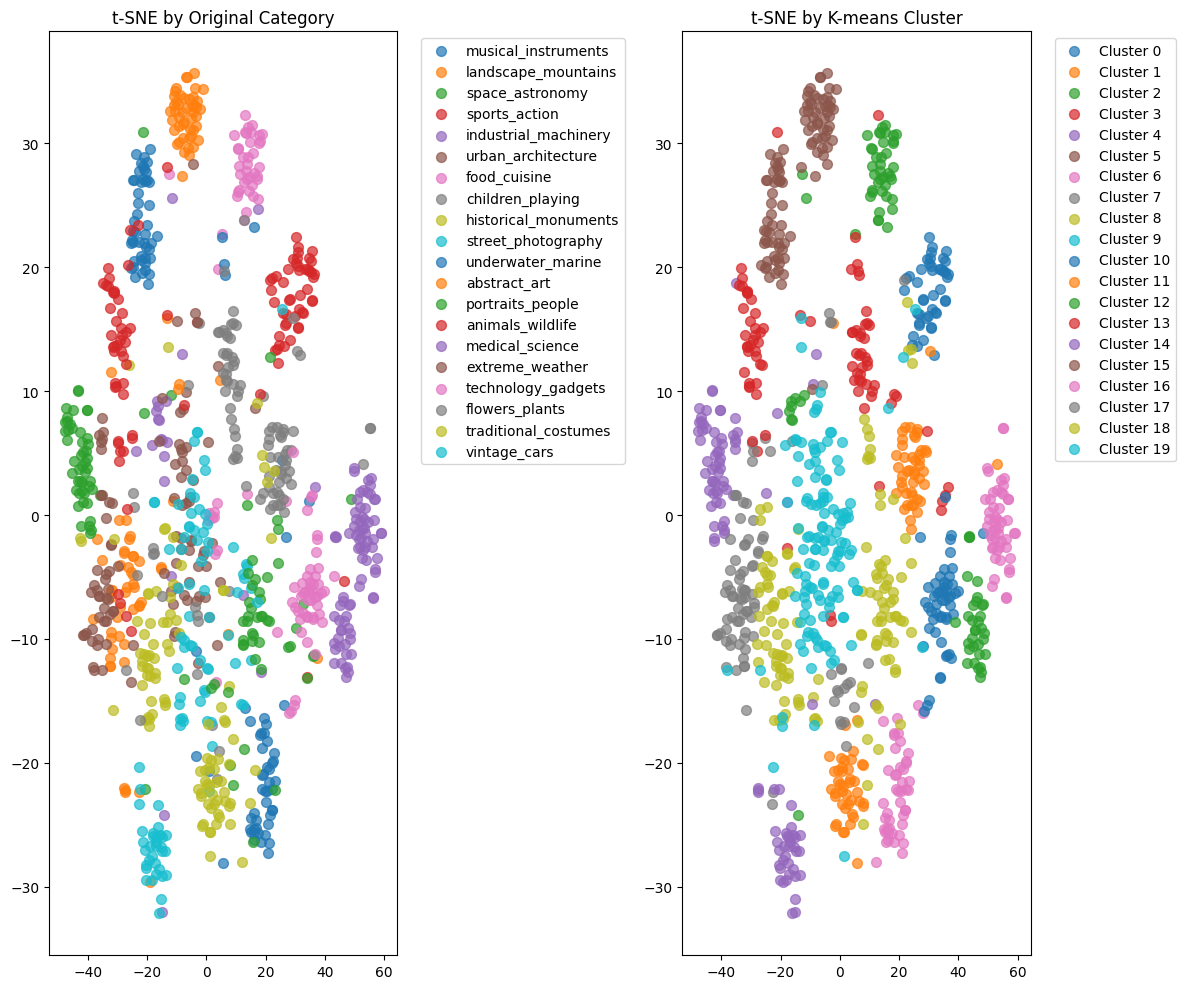

Analyzing cluster composition...

Cluster composition (counts):
cluster               0   1   2   3   4   5   6   7   8   9   10  11  12  13  \
category                                                                       
abstract_art           0   0   0   0   1  48   0   0   0   0   0   0   0   0   
animals_wildlife       0   0   0   1   1   0   0   6   3   1   0   0   0  34   
children_playing       2  38   0   3   1   0   0   1   2   0   0   2   0   0   
extreme_weather        0   0   0   2   6   1   0  39   1   1   0   0   0   0   
flowers_plants         0   1   1  31   0   0   0   0   4   1   0   0   0   0   
food_cuisine           0   1  38   2   0   0   0   0   0   0   0   0   0   0   
historical_monuments   0   0   0   0   2   0   1   1  30  13   0   0   0   1   
industrial_machinery   0   0   1   0   0   0   0   1   0   7   0   0  38   0   
landscape_mountains    0   0   0   1   0   0   0  22  19   1   1   0   0   1   
medical_science        0   0   0   1   1   0   0   0   0

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from transformers import CLIPProcessor, CLIPModel

# Set paths
data_root = "/kaggle/input/images-20"
metadata_path = os.path.join(data_root, "metadata.csv")

# Function to load all image paths
def load_image_paths(data_root):
    image_paths = []
    labels = []
    
    # Get all category directories
    categories = [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))]
    categories = [c for c in categories if not c.startswith('.')]  # Exclude hidden folders
    
    print(f"Found {len(categories)} categories")
    
    # For each category directory, get all images
    for category in categories:
        category_path = os.path.join(data_root, category)
        if not os.path.isdir(category_path):
            continue
            
        images = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for img in images:
            image_paths.append(os.path.join(category_path, img))
            labels.append(category)
    
    return image_paths, labels

# Function to generate embeddings using CLIP
def generate_embeddings(image_paths, batch_size=16):
    # Load CLIP model
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()
    
    embeddings = []
    
    # Process images in batches
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        
        # Load and process images
        images = []
        for path in batch_paths:
            try:
                img = Image.open(path).convert('RGB')
                images.append(img)
            except Exception as e:
                print(f"Error loading {path}: {e}")
                images.append(Image.new('RGB', (224, 224)))  # Placeholder for failed loads
        
        # Generate embeddings
        with torch.no_grad():
            inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
            image_features = model.get_image_features(**inputs)
            batch_embeddings = image_features.cpu().numpy()
            
        embeddings.append(batch_embeddings)
    
    # Concatenate all embeddings
    all_embeddings = np.vstack(embeddings)
    return all_embeddings

# Function to perform clustering
def perform_clustering(embeddings, n_clusters=10):
    # Normalize embeddings
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(normalized_embeddings)
    
    return cluster_labels, kmeans

# Function to visualize results
def visualize_clusters(embeddings, labels, cluster_labels, output_path="cluster_visualization.png"):
    # Use t-SNE to reduce dimensionality for visualization
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'category': labels,
        'cluster': cluster_labels
    })
    
    # Plot clusters
    plt.figure(figsize=(12, 10))
    
    # Plot by original category
    plt.subplot(1, 2, 1)
    categories = df['category'].unique()
    for category in categories:
        subset = df[df['category'] == category]
        plt.scatter(subset['x'], subset['y'], label=category, alpha=0.7, s=50)
    plt.title('t-SNE by Original Category')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot by cluster
    plt.subplot(1, 2, 2)
    clusters = sorted(df['cluster'].unique())
    for cluster in clusters:
        subset = df[df['cluster'] == cluster]
        plt.scatter(subset['x'], subset['y'], label=f'Cluster {cluster}', alpha=0.7, s=50)
    plt.title('t-SNE by K-means Cluster')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    
    return df

# Function to analyze cluster composition
def analyze_clusters(df):
    # Create a cross-tabulation of categories vs clusters
    cluster_analysis = pd.crosstab(df['category'], df['cluster'])
    
    # Calculate the percentage composition of each cluster
    cluster_percentages = cluster_analysis.div(cluster_analysis.sum(axis=0), axis=1) * 100
    
    return cluster_analysis, cluster_percentages

# Main execution
def main():
    # 1. Load image paths and categories
    print("Loading image paths...")
    image_paths, labels = load_image_paths(data_root)
    print(f"Found {len(image_paths)} images across {len(set(labels))} categories")
    
    # 2. Generate embeddings
    print("Generating embeddings...")
    embeddings = generate_embeddings(image_paths)
    print(f"Generated embeddings with shape: {embeddings.shape}")
    
    # 3. Perform clustering
    n_clusters = len(set(labels))  # Use the same number of clusters as categories
    print(f"Performing K-means clustering with {n_clusters} clusters...")
    cluster_labels, kmeans_model = perform_clustering(embeddings, n_clusters=n_clusters)
    
    # 4. Visualize results
    print("Visualizing clusters...")
    result_df = visualize_clusters(embeddings, labels, cluster_labels)
    
    # 5. Analyze cluster composition
    print("Analyzing cluster composition...")
    cluster_counts, cluster_percentages = analyze_clusters(result_df)
    print("\nCluster composition (counts):")
    print(cluster_counts)
    print("\nCluster composition (percentages):")
    print(cluster_percentages.round(1))
    
    # 6. Save embeddings and results
    results = {
        'image_paths': image_paths,
        'original_labels': labels,
        'embeddings': embeddings,
        'cluster_labels': cluster_labels
    }
    
    # Save results to file
    print("Saving results...")
    np.save('image_embeddings.npy', embeddings)
    pd.DataFrame({
        'image_path': image_paths,
        'original_category': labels,
        'cluster': cluster_labels
    }).to_csv('clustering_results.csv', index=False)
    
    print("Done!")

if __name__ == "__main__":
    main()